In [2]:
import pandas as pd
import requests
import datetime
import time
import json

In [3]:
base_url = 'https://api.pushshift.io/reddit/search/submission/'
parameters = {'subreddit': 'completeanarchy', 'title' : 'ACAB'}

In [4]:
r = requests.get(base_url, params = parameters)

In [5]:
reddit_df = pd.DataFrame(r.json()['data'])

In [6]:
def getPushshiftData(query, after, before, sub, endpoint = 'submission', size = 25):
    url = 'https://api.pushshift.io/reddit/search/' + endpoint
    parameters = {'subreddit': sub, 'title' : query, 'after' : str(after), 'before' : str(before), 'size': 500}
    r = requests.get(url, parameters)
    data = r.json()
    return data['data']

In [7]:
def collectSubData(subm, subStats):
    #subData = list() #list to store data points
    
    pd.DataFrame
    title = subm['title']
    url = subm['url']
    
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
        
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc'])
    numComms = subm['num_comments']
    permalink = subm['permalink']
    text = subm['selftext']
    
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair))
    subStats[sub_id] = subData

In [8]:
def extractStats(data):
    
    subStats = {}
    subCount = 0
    
    while len(data) > 0:
        print(len(data))
        for submission in data:
            collectSubData(submission, subStats)
            subCount+=1
            
        # Calls getPushshiftData() with the created date of the last submission
        print(len(data))
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
        after = data[-1]['created_utc']
        data = getPushshiftData(query, after, before, sub)

    print(len(data))
    return(subStats)

Code snippets from https://rareloot.medium.com/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [9]:
def dt2unix(before, after, format = "%Y/%m/%d"):
    # input: two strings in the form yyyy/mm/dd
    # returns: tuple (before, after) as unix times
    beforeUnix = time.mktime(datetime.datetime.strptime(before, format).timetuple())
    afterUnix = time.mktime(datetime.datetime.strptime(after, format).timetuple())
    return(int(beforeUnix), int(afterUnix))

In [10]:
query = 'ACAB'
before = 1538352000 # "1538352000" #October 1st
after = 1514764800  #January 1st 
before, after = dt2unix("2020/1/1","2017/10/1")
sub = 'news'
data = getPushshiftData(query, after, before, sub) # Will run until all posts have been gathered 
dataDF = pd.DataFrame(data)

In [11]:
dataDF.keys()

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link',
       'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'updated_utc', 'url', 'whitelist_status', 'wls'],
      dtype='object'

In [12]:
dataDF['full_link']

0    https://www.reddit.com/r/news/comments/cnw6h5/...
Name: full_link, dtype: object

In [13]:
def extractData(data):
    dataDF = pd.DataFrame(data)
    toExtract = ['author',
                 'subreddit',
                  'created_utc',
                  'full_link', 
                  'id', 'is_self', 
                  'is_video', 
                  'locked', 
                  'num_comments', 
                  'num_crossposts', 
                  'pinned', 
                  'score',
                 'selftext',
                  'title']
    return(dataDF[toExtract])

In [14]:
extractData(data)

,author,subreddit,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,title
0,corburruto,news,1565318691,https://www.reddit.com/r/news/comments/cnw6h5/...,cnw6h5,False,False,False,0,0,False,1,,"Interesting read, Reddit will hate it because ..."


In [15]:
list_of_subs = ['completeanarchy']

In [16]:
def getNews(query, after, before, sublist = ['news','worldnews','gunpolitics']):
    combinedDF = pd.DataFrame()
    for sub in sublist:
        datai = getPushshiftData(query, after, before, sub)
        while(len(datai) > 0):
            dataj = extractData(datai)
            combinedDF = combinedDF.append(dataj)
            before = datai[-1]['created_utc']
            print(before)
            datai = getPushshiftData(query, after, before, sub)
    return(combinedDF)

In [17]:
after, before = dt2unix('2019/05/1', '2019/10/01')
stories = getNews('heat wave', after, before)

1569236619
1567973568
1565826649
1565726524
1565691679
1565656413
1565162417
1565114840
1564967955
1564846833
1564702023
1564633117
1564540891
1564246379
1564192155
1564174422
1564130414
1564028834
1564004212
1563918625
1563782727
1563759654
1563750848
1563718626
1563685221
1563672279
1563667722
1563662019
1563658359
1563650947
1563646307
1563645944
1563625089
1563619396
1563619301
1563579193
1563572204
1563563359
1563556262
1563551376
1563515802
1563491613
1563407265
1563395829
1563386819
1563378454
1563363457
1562555719
1562535669
1562367699
1562366841
1562287800
1562187561
1562028071
1561970258
1561735618
1561728147
1561726263
1561648800
1561559623
1561539279
1561493014
1561409020
1561103917
1560337492
1558523953
1557941608


In [125]:
stories

,author,subreddit,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,title
0,ToddBBates,news,1557941608,https://www.reddit.com/r/news/comments/bp0vq2/...,bp0vq2,False,False,False,0,0,False,1,,Iceland Volcano Eruption in 1783-84 Did Not Sp...
1,drishtiias,news,1558523953,https://www.reddit.com/r/news/comments/brni3y/...,brni3y,False,False,False,0,0,False,1,,Heat Wave Warning-Drishti IAS
2,BarelyLegalSeagull,news,1560337492,https://www.reddit.com/r/news/comments/bzptu7/...,bzptu7,False,False,False,204,0,False,879,,Sweltering BART train reaches 107 degrees duri...
3,KevinSmith759,news,1561103917,https://www.reddit.com/r/news/comments/c37tle/...,c37tle,False,False,False,0,0,False,1,,Summer Heat Wave: Repair or Replace the AC?
4,RaspyRock,news,1561409020,https://www.reddit.com/r/news/comments/c4vci3/...,c4vci3,False,False,False,25,0,False,19,,"Massive, record-breaking heat wave in the brin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,drishtiias,news,1558523953,https://www.reddit.com/r/news/comments/brni3y/...,brni3y,False,False,False,0,0,False,1,,Heat Wave Warning-Drishti IAS
2,BarelyLegalSeagull,news,1560337492,https://www.reddit.com/r/news/comments/bzptu7/...,bzptu7,False,False,False,204,0,False,879,,Sweltering BART train reaches 107 degrees duri...
0,ToddBBates,news,1557941608,https://www.reddit.com/r/news/comments/bp0vq2/...,bp0vq2,False,False,False,0,0,False,1,,Iceland Volcano Eruption in 1783-84 Did Not Sp...
1,drishtiias,news,1558523953,https://www.reddit.com/r/news/comments/brni3y/...,brni3y,False,False,False,0,0,False,1,,Heat Wave Warning-Drishti IAS


In [112]:
print(before,after)

1569880800 1556661600


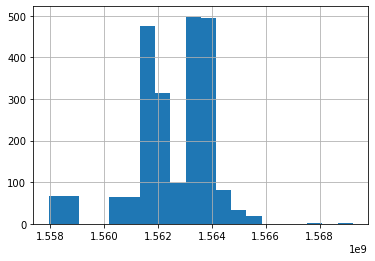

In [129]:
stories['created_utc'].hist(bins = 20)